### Biblioteki używane w rozwiązaniu zadań

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.optimize import golden
import itertools

# Zadanie 1

W tym zadaniu dla podanych poniżej funkcji:
- $f_1(x, y) = x^2 - 4xy + y^2$ 
- $f_2(x, y) = x^4 - 4xy + y^4$
- $f_3(x, y) = 2x^3 - 3x^2 -6xy(x - y - 1)$
- $f_4(x, y) = (x - y)^4 + x^2 - y^2 - 2x + 2y + 1$

należy wyznaczyć punkty krytyczne oraz określić ich rodzaj, tzn. czy jest to minimum, maksimum czy też punkt siodłowy.

Ponadto należy zbadać, czy te funkcje posiadają minimum / maksimum globalne na zbiorze $R^2$.

#### Jako że to zadanie nie wymaga zaprzęgnięcia narzędzi programistycznych, rozwiązanie znajduje się w sprawozdaniu.

# Zadanie 2

Szczegółowy opis modelu wraz z **wyprowadzeniem wzoru na gradient** oraz **opisem algorytmu** największego spadku z przeszukiwaniem liniowym, który służy do minimalizacji funkcji celu znajduje się w *sprawozdaniu*.

Funkcja celu ma postać:
$$
    F(x^{(0)}, x^{(1)},..., x^{(n)})=\lambda_1\sum_{i=0}^{n}\sum_{j=1}^{k}\frac{1}{\epsilon + ||x^{(i)}-r^{(j)}||_2^2} + \lambda_2\sum_{i=0}^{n-1}||x^{(i+1)}-x^{(i)}||^2_2,
$$
gdzie znaczenie poszczególnych wielkości jest określone również w sprawozdaniu.

---

Poniżej skupimy się raczej na implementacji algorytmu oraz przeprowadzeniu przykładowej symulacji dla badanego modelu z wykorzystaniem tego algorytmu. Spisujemy wartości parametrów algorytmu używane w symulacji.

In [2]:
# wartości parametrów algorytmu
n = 20
k = 50
x0 = [0, 0]
xn = [20, 20]
lambda1 = lambda2 = 1.
eps = 10 ** -13

iterations = 400
np.random.seed(12314)

# położenia przeszkód
R = np.random.uniform(0, 20, (k, 2))

Poniżej zapisujemy funkcję kosztu, której wzór był wspomniany powyżej.

In [3]:
def cost_function(X):
    part1 = 0.
    for i in range(n + 1):
        for j in range(k):
            part1 += 1. / (eps + np.square(np.linalg.norm(X[i] - R[j])))
            
    part2 = 0.
    for i in range(n):
        part2 += np.square(np.linalg.norm(X[i + 1] - X[i]))
        
    return lambda1 * part1 + lambda2 * part2

Przedstawiamy wyprowadzony wzór na gradient, którego będziemy używać w technice największego spadku do minimalizacji funkcji celu.

In [4]:
def fun_grad(X):
    grads = np.zeros_like(X)
    
    # ograniczamy zakres, bo chcemy pozostawić gradient skrajnych punktów na 0,
    # żeby algorytm nie próbował ich przesuwać, optymalizując funkcję kosztu
    for i in range(1, n):
        for j in range(k):
            grads[i] += (X[i] - R[j]) / ((eps + np.square(X[i] - R[j])) ** 2)
    
        grads[i] *= -2 * lambda1
        grads[i] += 2 * lambda2 * (X[i] - X[i - 1])
        grads[i] -= 2 * lambda2 * (X[i + 1] - X[i])
            
    return grads

### Przeszukiwanie liniowe

Zgodnie z poleceniem, używamy metody złotego podziału, która wymaga, aby funkcja $F$ była unimodalna.

Jako że tak w rzeczywistości **nie jest**, zakładamy, że jednak ta funkcja jest unimodalna oraz że można ustalić początkowy
przedział, w którym znajduje się minimum.

In [5]:
def line_search(X):
    costs = []
    copyX = copy.deepcopy(X)
    
    # metoda pomocnicza, którą będziemy przekazywać do metody złotego podziału
    def helper(xs, grad):
        return lambda alpha: cost_function(xs + alpha * grad)

    for i in range(iterations):
        costs.append(cost_function(copyX))
        grad = fun_grad(copyX)
        alpha = golden(helper(copyX, grad))

        # print(f"Step: {i}, Alpha: {alpha}, Cost: {cost_function(copyX)}, Grad Norm: {np.linalg.norm(grad)}")

        copyX += alpha * grad
        
        # jeśli kroki stają się zbyt małe - zwracamy aktualną wartość jeszcze przed przebiegiem wszystkich iteracji
        if np.linalg.norm(grad * alpha) < eps:
            break

    return (copyX, costs)

Poniżej prezentujemy funkcje do wizualizacji ścieżki robota oraz kreślenia wykresu funkcji kosztu.

In [6]:
# funkcja do wizulizacji ścieżki robota X i położenia przeszkód R
def plot_path(X, R,  name, plot_coordinates = False):
    plt.figure(figsize = (10, 10))
    plt.plot(X[:, 0], X[:, 1], marker = 'o', linestyle = '-', color = 'b', label = 'Robot Path')
    plt.scatter(X[:, 0], X[:, 1], color = 'b')
    plt.scatter(R[:, 0], R[:, 1], color = 'r', marker = 'x', label = 'Obstacles')

    # dodanie współrzędnych punktów ścieżki oraz przeszkód do wykresu
    if plot_coordinates:
        for i, (x, y) in enumerate(X):
                plt.text(x, y, f'({x:.1f}, {y:.1f})', fontsize = 9, ha = 'right')

        for i, (x, y) in enumerate(R):
            plt.text(x, y, f'({x:.1f}, {y:.1f})', fontsize = 9, ha = 'left')

    # numeracja punktów, żeby można było odtworzyć kolejność kroków robota
    for i, (x, y) in enumerate(X):
            plt.text(x, y, f'({i})', fontsize = 9, ha = 'right')

    plt.ylim(-1, 21)
    plt.grid(True)
    plt.legend()

    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Robot Path and Obstacles ' + name + ' training')

    plt.show()

In [7]:
def plot_cost_function(costs_list):
    colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])  # używamy zbioru kolorów cyklicznie
    plt.figure(figsize = (10, 8))

    for costs, color in zip(costs_list, colors):
        iterations = range(1, len(costs) + 1)
        plt.plot(iterations, costs, marker = 'o', linestyle = '-', color = color, 
                 label = f'Cost Function {costs_list.index(costs) + 1}')

    plt.title('Cost Function Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    plt.show()

Obliczenia przeprowadzamy dla 5 różnych losowych inicjalizacji punktów wewnątrz ścieżki $x^{(1)}, . . . , x^{(n−1)}$. Następnie rysujemy wykres wartości funkcji $F$ w zależności od iteracji.

In [8]:
XS = []
costs = []
results = []

for i in range(5):
    # początkowe wartości x-ów
    X = np.vstack((x0, np.random.uniform(0, 20, (n - 1, 2)), xn))

    XS.append(X)

    (result, cost) = line_search(X)
    results.append(result)
    costs.append(cost)

    # zmiana seedu na nowy, ale również deterministycznie
    next_seed = np.random.randint(0, 1000)
    np.random.seed(next_seed)

Zobaczmy, jak wygląda przykładowa ścieżka robota przed optymalizacją oraz po niej.

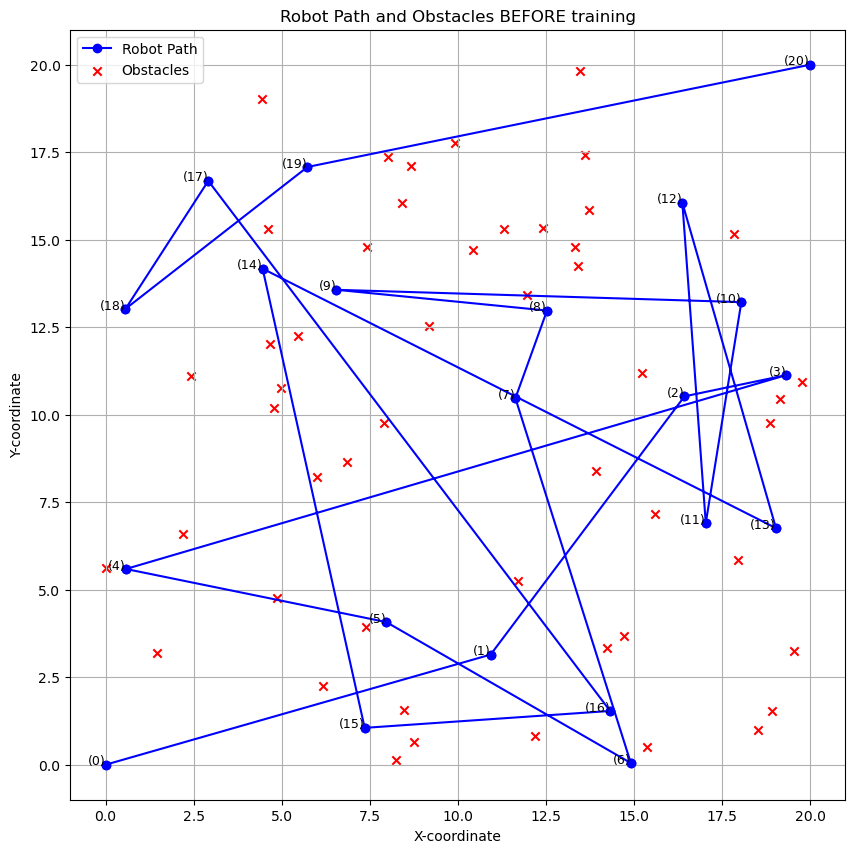

In [13]:
# ścieżka robota przed optymalizacją, po wylosowaniu
plot_path(XS[0], R, "BEFORE")

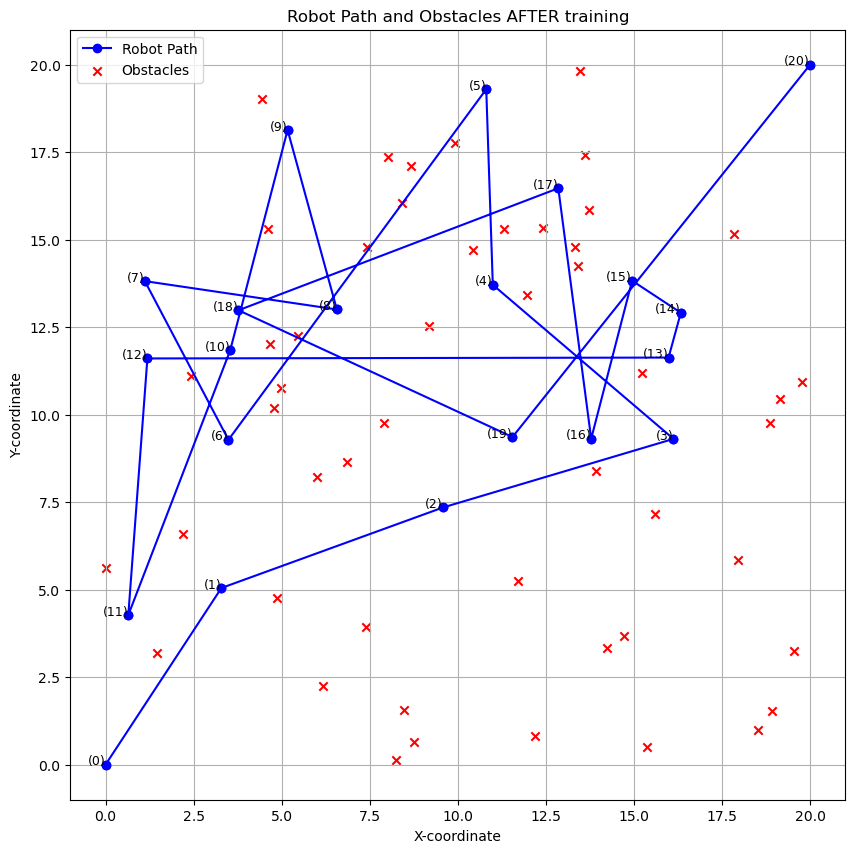

In [10]:
# ścieżka robota po optymalizacji
plot_path(results[0], R, "AFTER")

Na koniec przedstawiamy wartości funkcji kosztu przed optymalizacją oraz po optymalizacji dla każdego przypadku oraz wykresy wartości wszystkich funkcji kosztu (dla każdego przypadku, w zależności od iteracji).

In [14]:
for i in range(5):
    print("Case number", i + 1)
    print("Cost function before training: ", cost_function(XS[i]))
    print("Cost function after training: ", cost_function(results[i]))
    print()

Case number 1
Cost function before training:  2415.71954231458
Cost function after training:  912.5819187018278

Case number 2
Cost function before training:  2763.8807245389075
Cost function after training:  1230.8660287044745

Case number 3
Cost function before training:  2187.1252253279768
Cost function after training:  1895.79142946409

Case number 4
Cost function before training:  2035.3202580392901
Cost function after training:  1120.3192538841306

Case number 5
Cost function before training:  2588.3688050704254
Cost function after training:  1293.4084566132074



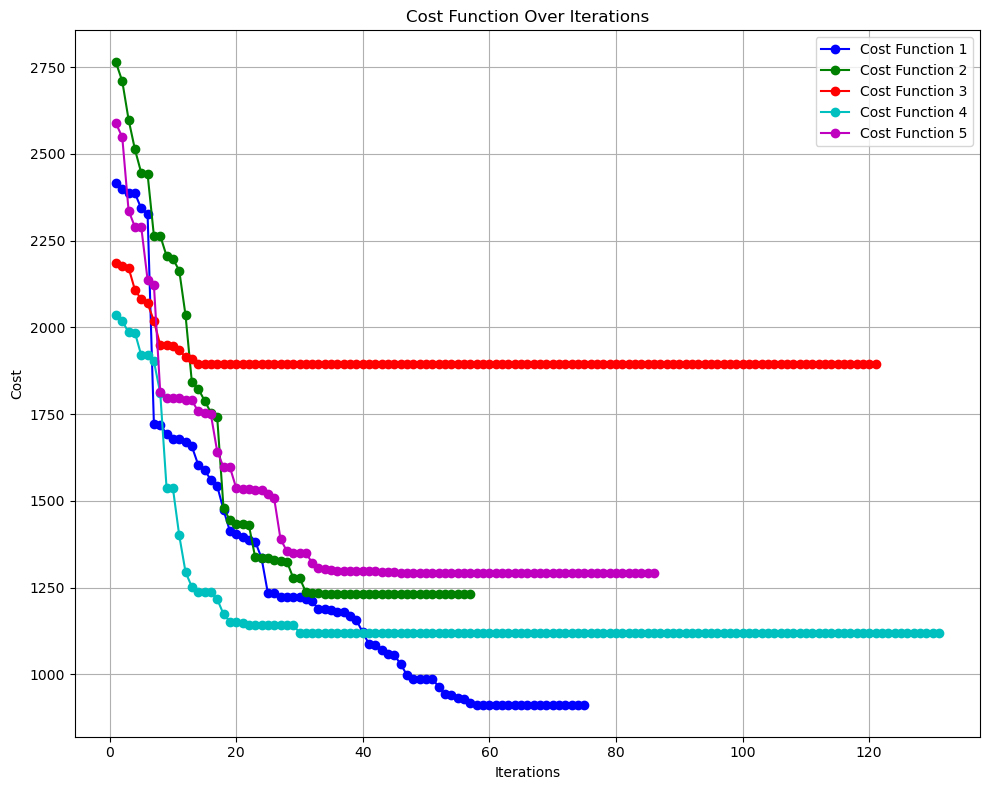

In [15]:
# Wykres wspólny funkcji kosztu
plot_cost_function(costs)